# [머신러닝의 해석] 5편. 모델에 영향을 주는 교호작용 파악: ICE plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import plot_partial_dependence, partial_dependence

sns.set_style('whitegrid')
matplotlib.rcParams['figure.dpi'] = 150

df = pd.read_csv("adult_new.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,Private,132870,HS-grad,2,Separate,Exec-managerial,Not-in-family,White,Female,0,4356,18,US,<=50K
1,54,Private,140359,HS-under,1,Separate,Machine-op-inspct,Unmarried,White,Female,0,3900,40,US,<=50K
2,41,Private,264663,College,3,Separate,Prof-specialty,Own-child,White,Female,0,3900,40,US,<=50K
3,34,Private,216864,HS-grad,2,Separate,Other-service,Unmarried,White,Female,0,3770,45,US,<=50K
4,38,Private,150601,HS-under,1,Separate,Adm-clerical,Unmarried,White,Male,0,3770,40,US,<=50K


In [2]:
y = df.income
X = df.drop(['income','fnlwgt','education'],axis=1)

#categorical features labeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

for i in ['workclass','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']:
    X[i] = le.fit_transform(X[i])

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=123, stratify=y)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=10).fit(X_train, y_train)
print('train set accuracy: ',metrics.accuracy_score(y_train, rf.predict(X_train)))
print('test set accuracy: ', metrics.accuracy_score(y_test, rf.predict(X_test)))

train set accuracy:  0.8712512205328498
test set accuracy:  0.8568019093078759


In [4]:
X_train.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
6374,34,1,5,2,9,4,4,0,0,0,40,0
24793,24,3,4,0,6,0,4,1,0,0,40,0
5801,51,3,1,0,13,0,4,1,0,0,40,0
18781,19,3,3,1,7,3,4,0,0,0,18,0
25603,25,3,1,0,6,0,3,1,0,0,40,1


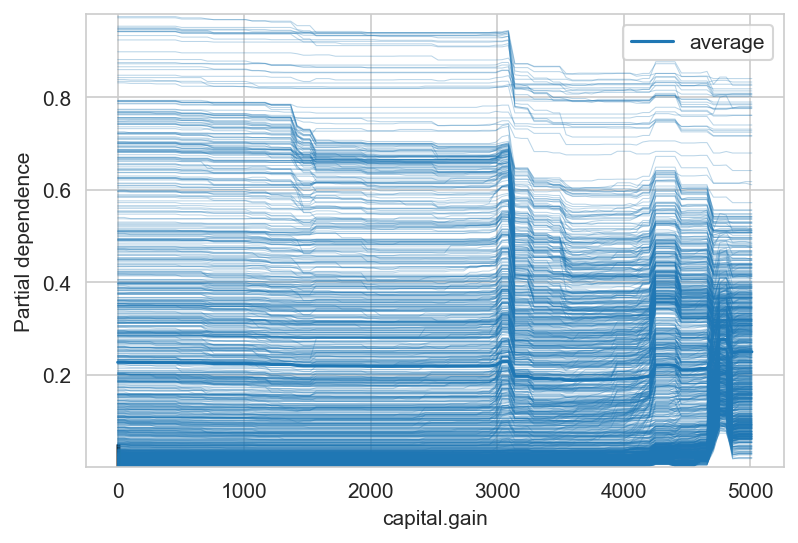

In [5]:
plot_partial_dependence(rf, X_train, [8], kind='both')

In [7]:
pdp = partial_dependence(rf, X_train, 'relationship', kind='both')
pdp

{'average': array([[0.30198822, 0.21293779, 0.20295734, 0.21004233, 0.21433194,
         0.29733345]]),
 'individual': array([[[0.33776679, 0.11462064, 0.10412762, 0.10279376, 0.10621289,
          0.27042846],
         [0.13300393, 0.10548901, 0.09132298, 0.09277342, 0.09309962,
          0.18922493],
         [0.19103569, 0.15492569, 0.14628498, 0.18706696, 0.18876257,
          0.23662658],
         ...,
         [0.82549092, 0.59849244, 0.59869878, 0.60965869, 0.61440263,
          0.76909122],
         [0.07481668, 0.00946119, 0.00779469, 0.00723124, 0.01828735,
          0.11200268],
         [0.92505133, 0.6594733 , 0.67244097, 0.70083763, 0.7143547 ,
          0.80958018]]]),
 'values': [array([0, 1, 2, 3, 4, 5])]}

In [8]:
def labeling_name(df,X,feature_name):
    feature_info = pd.concat([df[feature_name], X[feature_name]],axis=1).drop_duplicates()
    feature_info.columns = ['category','label']
    feature_info = feature_info.sort_values('label').reset_index(drop=True)
    return feature_info

In [9]:
def plot_ICE(model,data,col,n_sample=500):
    pdp = partial_dependence(model, data, col, kind='both')
    average = pdp['average'][0]
   
    x = pdp['values'][0]
    n_level = len(x)
    ice = pd.DataFrame(pdp['individual'][0])
    
    ice = ice.sample(n_sample, random_state=0)    
    
    for idx in range(ice.shape[0]):
        plt.plot(x,ice.iloc[idx,:n_level], c='gray', alpha=0.8, linewidth=0.6)
    plt.plot(x,average, c='#f2a154', linewidth=4)    
    
    plt.title("ICE plot for %s" %col)
    plt.xlabel('%s' %col)
    plt.ylabel('y_hat')

In [10]:
import random

def plot_ICE_hue(model,data,col,hue,n_sample=500):
    pdp = partial_dependence(model, data, col, kind='individual')
    x = pdp['values'][0]
    n_level = len(x)
    ice = pd.DataFrame(pdp['individual'][0])
    data = data.reset_index(drop=True)
    ice[hue] = data[hue]
    
    ice = ice.sample(n_sample,random_state=0)

    #hue color
    colors = dict()
    for level in data[hue].unique():
        colors[level] = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 
    ice['color'] = ice[hue].apply(lambda x: colors[x])
    
    #ICE plot
    for idx in range(ice.shape[0]):
        plt.plot(x,ice.iloc[idx,:n_level], c=ice.iloc[idx,:]['color'], alpha=0.8, linewidth=0.6)
    
    #hue legend
    from matplotlib.lines import Line2D 
    lines = [Line2D([0], [0], color=c) for c in colors.values()]
    labels = [name for name in colors.keys()]
    plt.legend(lines,labels)
    
    plt.title("ICE plot for %s according to %s" %(col,hue))
    plt.xlabel('%s' %col)
    plt.ylabel('y_hat')

In [11]:
labeling_name(df,X,'marital.status')

,category,label
0,Married,0
1,Never married,1
2,Separate,2


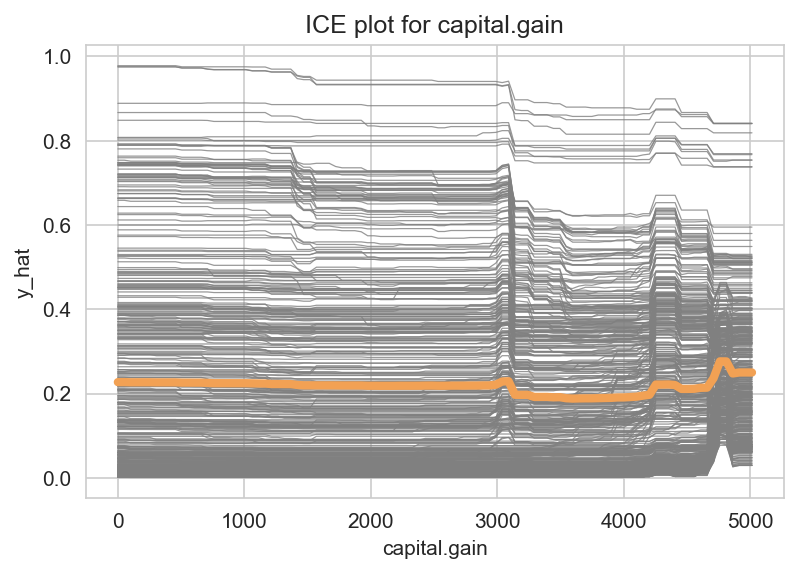

In [12]:
plot_ICE(rf, X_train,'capital.gain')

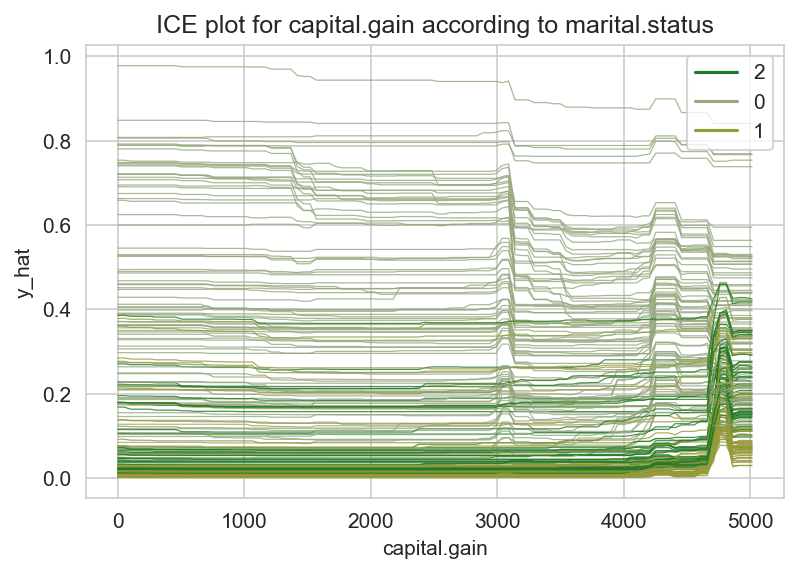

In [13]:
plot_ICE_hue(rf, X_train, 'capital.gain', 'marital.status', 200)

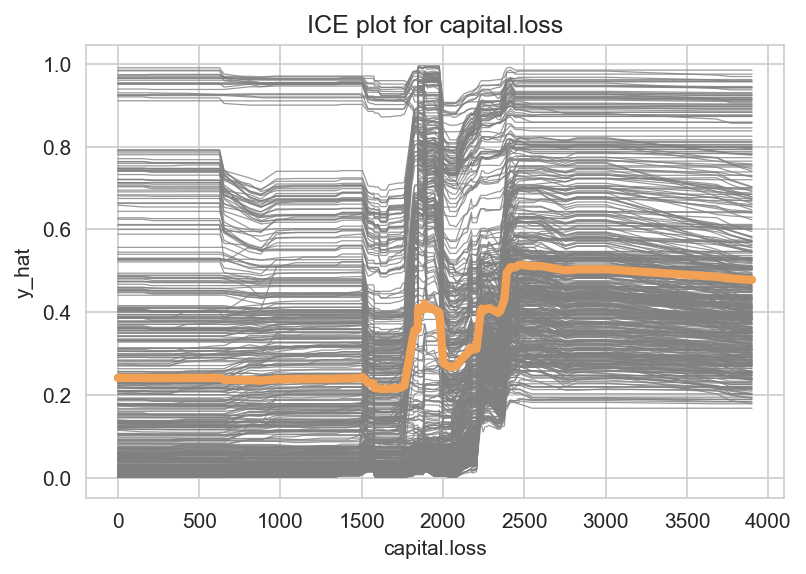

In [14]:
plot_ICE(rf, X_train,'capital.loss')

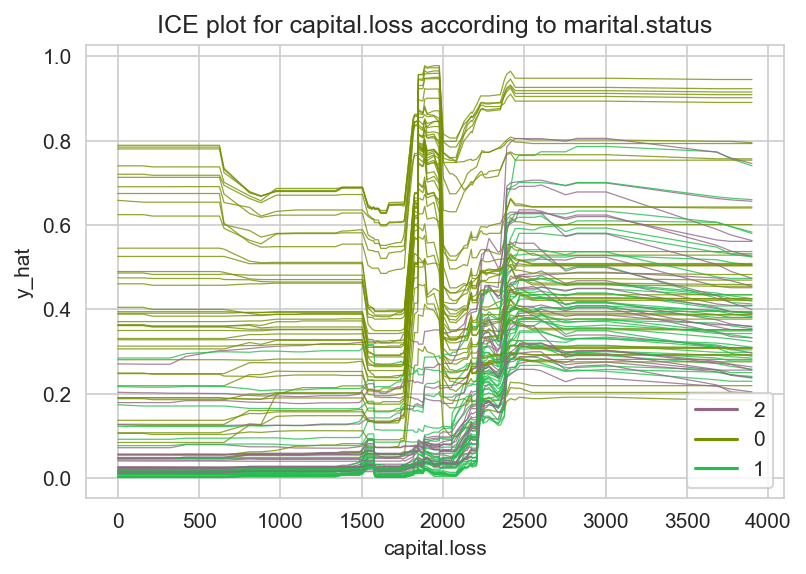

In [15]:
plot_ICE_hue(rf, X_train, 'capital.loss', 'marital.status', 100)

---

# Medium

[Medium: Finding and Visualising Interactions](https://towardsdatascience.com/finding-and-visualising-interactions-14d54a69da7c)

In [7]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

In [3]:
def generate_row():
    """
    Generate one random employee for the dataset
    """
    
    experience = random.randint(0,40)
    degree = int(random.random() < 0.75)
    performance = round(random.random()*10,2)
    sales = random.randint(0,100)
    days_late = random.randint(0,20)
    
    return {'experience':experience, 
            'degree':degree, 
            'performance':performance,
            'sales':sales,
           'days_late':days_late}

def bonus_row(employee,a=0,b=20,c=5,d=2,e=1/5,f=1/5,g=-1):
    """
    bonus an employee based on employee data
    """
    bonus = 0
    
    bonus+=a*employee['experience']
    bonus+=b*employee['degree']
    bonus+=c*employee['experience']*employee['degree']
    bonus+= d*employee['performance']
    bonus+= e*employee['sales']
    bonus+= f*employee['sales']*employee['performance']
    bonus+= g*employee['days_late']
    
    bonus += random.randint(-20,20)
    
    return round(bonus)

employee=generate_row()
print(employee)
bonus_row(employee)

data_dics = []
for i in range(1000):
    random_employee = generate_row()
    bonus = bonus_row(random_employee)
    random_employee['bonus'] = max(bonus,0)
    data_dics.append(random_employee)
    
data  = pd.DataFrame(data_dics,columns=['experience', 'degree','performance', 'sales','days_late', 'bonus'])

{'experience': 28, 'degree': 1, 'performance': 4.73, 'sales': 38, 'days_late': 9}


In [4]:
data.head()

,experience,degree,performance,sales,days_late,bonus
0,26,1,8.86,57,16,282
1,25,0,6.87,43,12,67
2,8,0,9.80,22,1,82
3,6,0,6.30,2,19,0
4,17,0,9.33,20,18,33


In [9]:
features = ['experience', 'degree', 'performance', 'sales']
X = data[features]
y = data['bonus']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 101)
# Fitting the model
rf = RandomForestRegressor(n_estimators=500, max_depth=10)
rf.fit(x_train, y_train)

# Prediction and evaluation
train_preds = rfc.predict(x_train)
test_preds = rfc.predict(x_test)

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_preds))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_preds))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_preds)))

Mean Absolute Error: 12.825295985526445
Mean Squared Error: 251.0408444848467
Root Mean Squared Error: 15.844268505830325


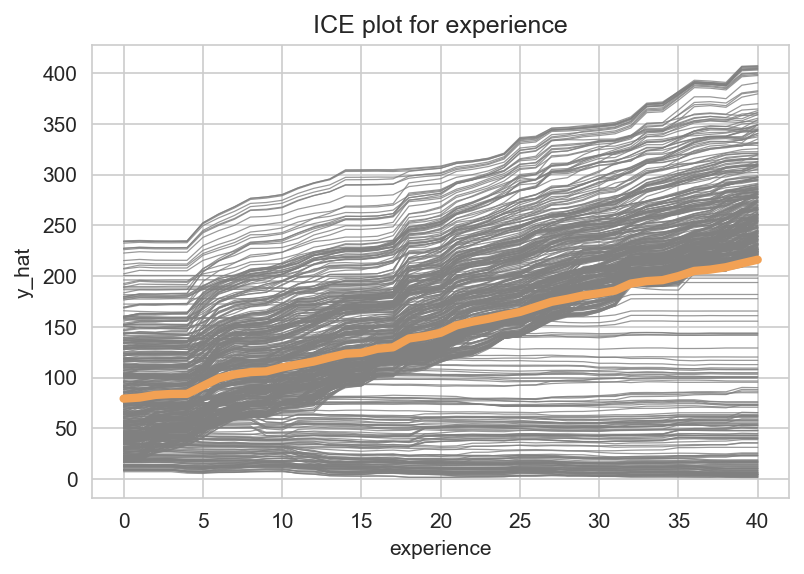

In [24]:
fig = plot_ICE(rfc, X, 'experience')
plt.savefig("ice1.png", dpi=300)

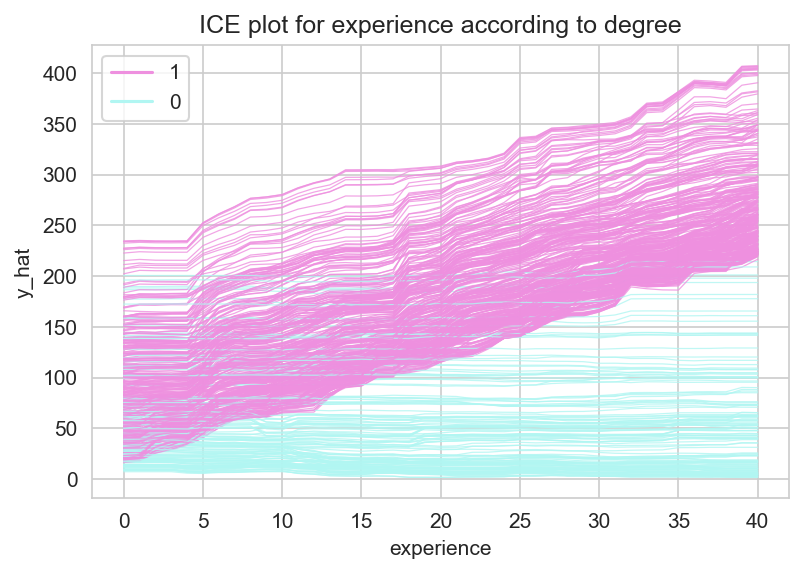

In [29]:
plot_ICE_hue(rfc, X, 'experience', 'degree')
plt.savefig("ice2.png", dpi=300)